In [1]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cpi
import matplotlib.ticker as ticker

# setting plt to inline
%matplotlib inline

# updating cpi if flagged out of date
# cpi.update()

In [2]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query functions
def fetcha(q):
    return cur.execute(q).fetchall()
def fetcho(q):
    return cur.execute(q).fetchone()

In [3]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [4]:
q = "PRAGMA table_info('rotten_tomatoes_movies')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'rotten_tomatoes_link', 'TEXT', 0, None, 0),
 (2, 'movie_title', 'TEXT', 0, None, 0),
 (3, 'movie_info', 'TEXT', 0, None, 0),
 (4, 'critics_consensus', 'TEXT', 0, None, 0),
 (5, 'content_rating', 'TEXT', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0),
 (7, 'directors', 'TEXT', 0, None, 0),
 (8, 'authors', 'TEXT', 0, None, 0),
 (9, 'actors', 'TEXT', 0, None, 0),
 (10, 'original_release_date', 'TEXT', 0, None, 0),
 (11, 'streaming_release_date', 'TEXT', 0, None, 0),
 (12, 'runtime', 'REAL', 0, None, 0),
 (13, 'production_company', 'TEXT', 0, None, 0),
 (14, 'tomatometer_status', 'TEXT', 0, None, 0),
 (15, 'tomatometer_rating', 'REAL', 0, None, 0),
 (16, 'tomatometer_count', 'REAL', 0, None, 0),
 (17, 'audience_status', 'TEXT', 0, None, 0),
 (18, 'audience_rating', 'REAL', 0, None, 0),
 (19, 'audience_count', 'REAL', 0, None, 0),
 (20, 'tomatometer_top_critics_count', 'INTEGER', 0, None, 0),
 (21, 'tomatometer_fresh_critics_count', 'INTEGER', 0, N

In [5]:
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

In [6]:
# creating initial dataframe by joining the four tables and printing first row
q = """SELECT*FROM rotten_tomatoes_movies AS rt
       JOIN tn_movie_budgets AS tn
       ON rt.movie_title = tn.movie
       
       """
dfr = pd.DataFrame(fetcha(q))
dfr.columns = [i[0] for i in cur.description]   

In [7]:
# # dropping extraneous columns
# df = df.drop(['idx', 'rotten_tomatoes_link', 'movie_info', 'critics_consensus', 'directors',\
#              'authors', 'actors', 'original_release_date', 'streaming_release_date',\
#              'runtime', 'production_company', 'tomatometer_status', 'tomatometer_rating',\
#              'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count',\
#              'id', 'movie'], axis=1)
# df.head(1)

In [8]:
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')

In [9]:
dfr.isna().sum()

idx                                   0
rotten_tomatoes_link                  0
movie_title                           0
movie_info                           35
critics_consensus                   642
content_rating                        0
genres                                0
directors                            52
authors                             119
actors                               14
original_release_date                64
streaming_release_date               38
runtime                              35
production_company                   17
tomatometer_status                    3
tomatometer_rating                    3
tomatometer_count                     3
audience_status                      31
audience_rating                      12
audience_count                       13
tomatometer_top_critics_count         0
tomatometer_fresh_critics_count       0
tomatometer_rotten_critics_count      0
idx                                   0
id                                    0


In [10]:
# changing actor name NaNs to strings
dfr['actors'] = dfr['actors'].fillna('NaN')

In [11]:
# change date string to datetime object 
dfr.release_date = pd.to_datetime(dfr.release_date)
dfr['year'] = dfr['release_date'].apply(lambda x: x.year)
dfr['month'] = dfr['release_date'].apply(lambda x: x.month)

In [12]:
#cleaning numerical strings and converting to floats
dfr['worldwide_gross'] = dfr['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['domestic_gross'] = dfr['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['production_budget'] = dfr['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [13]:
# adding intl gross column
dfr['international_gross'] = dfr['worldwide_gross'].sub(dfr['domestic_gross'])

In [14]:
# adding net profit columns
dfr['domestic_net'] = dfr['domestic_gross'].sub(dfr['production_budget'])
dfr['worldwide_net'] = dfr['worldwide_gross'].sub(dfr['production_budget'])
dfr['international_net'] = dfr['international_gross'].sub(dfr['production_budget'])

In [15]:
# adding roi columns
dfr['domestic_roi'] = dfr['domestic_net'].divide(dfr['production_budget'])
dfr['worldwide_roi'] = dfr['worldwide_net'].divide(dfr['production_budget'])
dfr['international_roi'] = dfr['international_net'].divide(dfr['production_budget'])

In [16]:
dfr#adding adjust gross profit and budget columns
dfr['adj_dom_gross'] = dfr.apply(lambda x: cpi.inflate(x.domestic_gross, x.year), axis=1)
dfr['adj_ww_gross'] = dfr.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
dfr['adj_i_gross'] = dfr.apply(lambda x: cpi.inflate(x.international_gross, x.year), axis=1)
dfr['adj_prod_budg'] = dfr.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)

In [17]:
#adding net profit columns
dfr['adj_dom_net'] = dfr['adj_dom_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_ww_net'] = dfr['adj_ww_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_i_net'] = dfr['adj_i_gross'].sub(dfr['adj_prod_budg'])

In [18]:
#adding adjusted return on investment columns and checking results
dfr['adj_dom_roi'] = dfr['adj_dom_net'].divide(dfr['adj_prod_budg'])
dfr['adj_ww_roi'] = dfr['adj_ww_net'].divide(dfr['adj_prod_budg'])
dfr['adj_i_roi'] = dfr['adj_i_net'].divide(dfr['adj_prod_budg'])
dfr.head(1)

,idx,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,1.040753e+08,2.615132e+08,1.574379e+08,1.113815e+08,-7.306274e+06,1.501316e+08,4.605635e+07,-0.065597,1.347904,0.413501


In [19]:
# checking column names
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'year', 'month',
       'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

In [20]:
# renaming columns
dfr = dfr.rename(columns = {'movie_title':'title', 'release_date':'date',\
                          'content_rating': 'rating', 'genres': 'genres',\
                          'tomatometer_top_critics_count': 'top', 'tomatometer_fresh_critics_count': 'fresh',\
                          'tomatometer_rotten_critics_count': 'rotten'})
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'title', 'movie_info',
       'critics_consensus', 'rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'top', 'fresh', 'rotten', 'idx', 'id', 'date',
       'movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

## Top 100 Films by Worldwide Gross

In [21]:
# creating dataframes sorted by gross
title_gross = dfr[['title', 'production_budget', 'worldwide_gross', 'worldwide_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_gross_titles = title_gross.drop_duplicates(subset = ['title'])
top100_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(100)
top20_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(20)

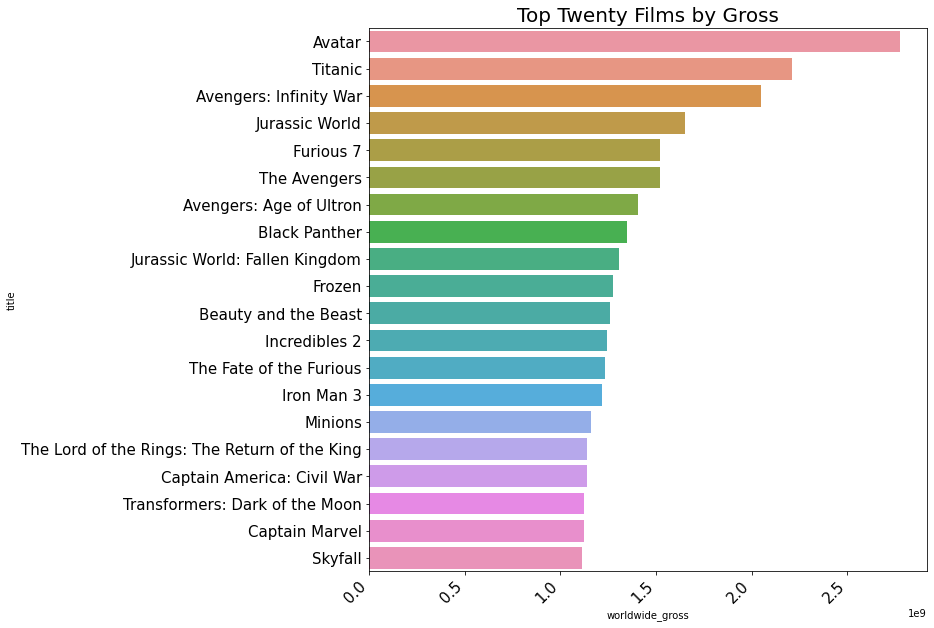

In [22]:
# plotting top 20 films by gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_gross', y='title', data= top20_gross_films)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_title('Top Twenty Films by Gross', size = 20)
plt.show()

In [23]:
# top 100 by gross basic stats
print(f'mean {top100_gross_films.production_budget.mean()}')
print(f'median {top100_gross_films.production_budget.median()}')
print(f'min {top100_gross_films.production_budget.min()}')
print(f'max {top100_gross_films.production_budget.max()}')
top100_gross_films.describe()

mean 168575000.0
median 172500000.0
min 35000000.0
max 425000000.0


,production_budget,worldwide_gross,worldwide_net,worldwide_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.685750e+08,9.576570e+08,7.890820e+08,5.846388,2011.340000,7.250000
std,7.397127e+07,3.273300e+08,3.019174e+08,3.688244,6.067333,2.903759
min,3.500000e+07,6.522201e+08,3.559452e+08,1.186484,1993.000000,2.000000
25%,1.100000e+08,7.578371e+08,6.014434e+08,3.236404,2009.000000,5.000000
50%,1.725000e+08,8.794230e+08,7.003720e+08,4.513429,2013.000000,6.000000
75%,2.000000e+08,1.040525e+09,8.783895e+08,7.029846,2016.000000,11.000000
max,4.250000e+08,2.776345e+09,2.351345e+09,18.927371,2019.000000,12.000000


|Budget Stat       |Dollar Amount      |
|:-----------------|------------------:|
|Mean Budget       |       168,575,000 |
|Median Budget     |       172,500,000 |
|Min Budget        |        35,000,000 |
|Max Budget        |        425,000,000|

In [24]:
# creating dataframes sorted by adjusted gross
title_adj_gross = dfr[['title', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi', 'genres', 'year', 'month']]
unique_adj_titles = title_adj_gross.drop_duplicates(subset = ['title'])
top100_adj_gross_films = unique_adj_titles.sort_values(by='adj_ww_gross', ascending=False).head(100)
top20_adj_gross_films = unique_adj_titles.sort_values(by='adj_ww_gross', ascending=False).head(20)

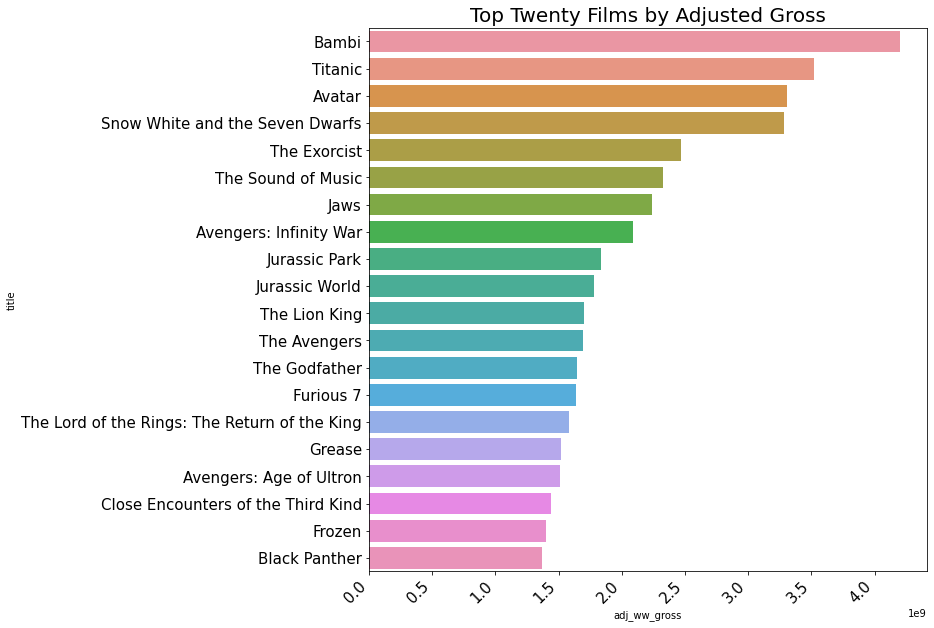

In [25]:
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='adj_ww_gross', y='title', data= top20_adj_gross_films)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_title('Top Twenty Films by Adjusted Gross', size = 20)
plt.show()

In [26]:
# top 100 by adjusted gross basic stats
print(f'mean {top100_adj_gross_films.adj_prod_budg.mean()}')
print(f'median {top100_adj_gross_films.adj_prod_budg.median()}')
print(f'min {top100_adj_gross_films.adj_prod_budg.min()}')
print(f'max {top100_adj_gross_films.adj_prod_budg.max()}')
top100_adj_gross_films.describe()

mean 168748084.47432208
median 179232282.51574492
min 4493093.145869947
max 506459142.2458597


,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.687481e+08,1.277631e+09,1.108883e+09,16.019202,2001.810000,7.580000
std,9.581017e+07,5.732113e+08,5.769721e+08,39.681137,17.395399,3.012365
min,4.493093e+06,8.547247e+08,6.252047e+08,1.546673,1937.000000,2.000000
25%,8.805160e+07,9.490569e+08,8.062123e+08,4.006988,1994.000000,5.000000
50%,1.792323e+08,1.115988e+09,9.634766e+08,5.697061,2008.500000,7.000000
75%,2.201631e+08,1.304167e+09,1.156453e+09,11.970308,2015.000000,11.000000
max,5.064591e+08,4.203440e+09,4.189983e+09,311.354312,2019.000000,12.000000


In [27]:
top100_adj_gross_films[top100_adj_gross_films['adj_prod_budg'] == top100_adj_gross_films['adj_prod_budg'].min()]

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,genres,year,month
270,Rocky,4.493093e+06,1.010946e+09,1.006453e+09,224.0,"Drama, Sports & Fitness",1976,11


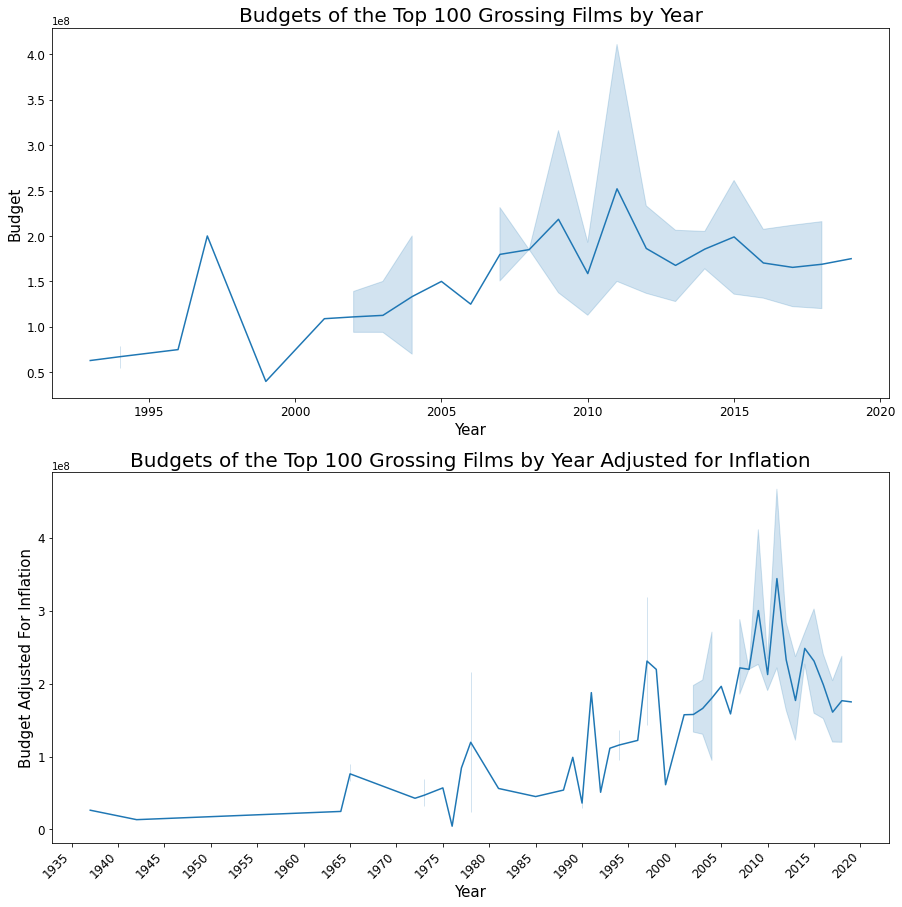

In [28]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(15,15))
sns.lineplot(x='year', y='production_budget', data=top100_gross_films, ax=ax1)
sns.lineplot(x='year', y='adj_prod_budg', data=top100_adj_gross_films, ax=ax2)
# adjusting xticks
plt.xticks(rotation=45, ha='right')
ax1.tick_params(labelsize=12) 
ax2.tick_params(labelsize=12)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())

# label for x-axis 
ax1.set_xlabel( "Year", size = 15 )
ax2.set_xlabel( "Year", size = 15 ) 
# label for y-axis 
ax1.set_ylabel( "Budget", size = 15 ) 
ax2.set_ylabel( "Budget Adjusted For Inflation", size = 15 ) 
# title for plot 
ax1.set_title( "Budgets of the Top 100 Grossing Films by Year" , size = 20 )
ax2.set_title( "Budgets of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 20 ) 
plt.show()

In [29]:
t100_count_by_year = pd.DataFrame(top100_gross_films.year.value_counts()).reset_index()
t100_count_by_year = t100_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_count_by_year.head(1)

,year,count
0,2017,11


In [30]:
t100_adj_count_by_year = pd.DataFrame(top100_adj_gross_films.year.value_counts()).reset_index()
t100_adj_count_by_year = t100_adj_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_adj_count_by_year.head(1)

,year,count
0,2017,7


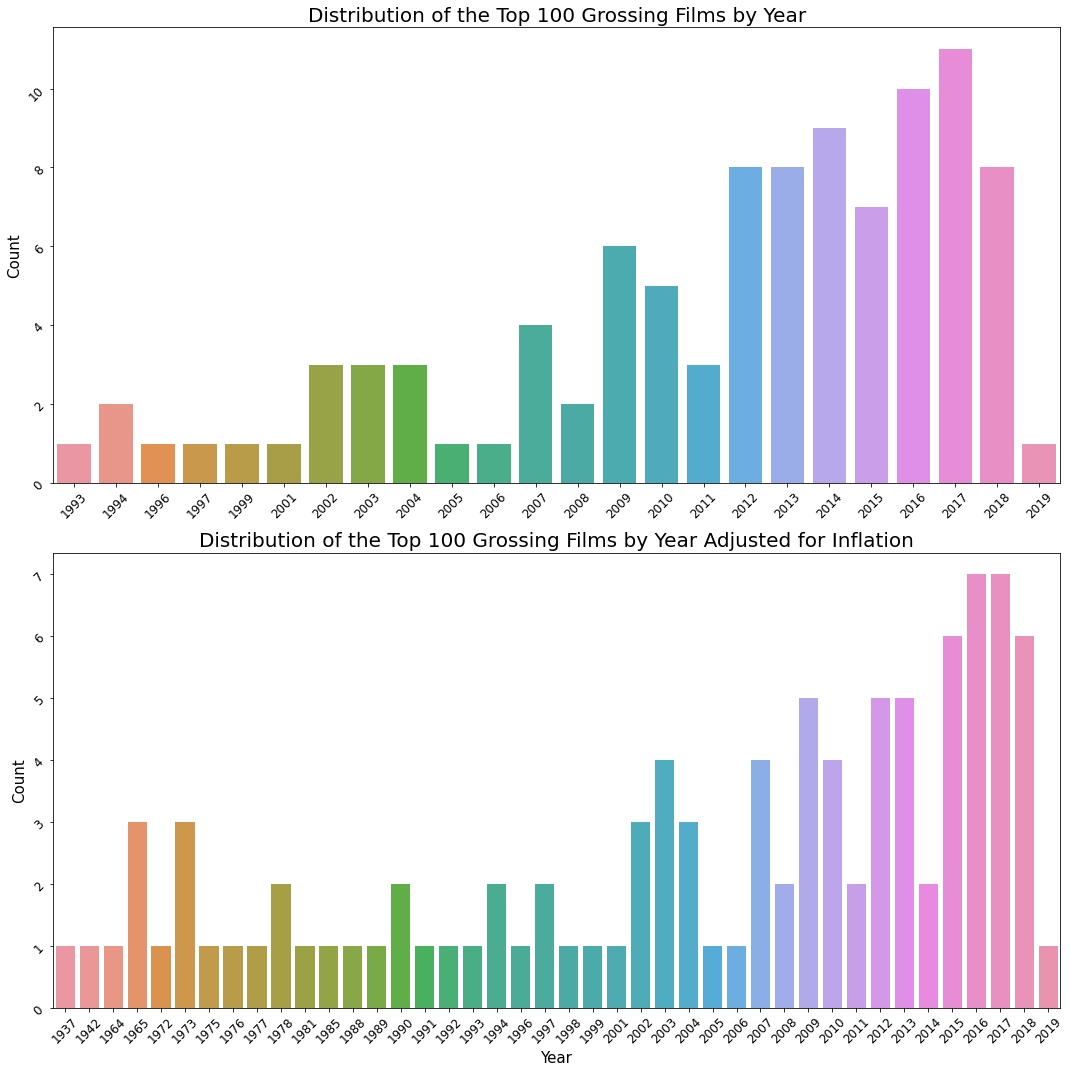

In [31]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(15,15))
sns.barplot(x='year', y= 'count', data=t100_count_by_year, ax = ax1)
sns.barplot(x='year', y= 'count', data=t100_adj_count_by_year, ax = ax2)
# adjusting xticks
for ax in fig.axes:
    ax.tick_params(labelrotation=45)
ax1.tick_params(labelsize=12) 
ax2.tick_params(labelsize=12)
# label for x-axis 
ax1.set_xlabel( "", size = 15 )
ax2.set_xlabel( "Year", size = 15 ) 
# label for y-axis 
ax1.set_ylabel( "Count", size = 15 ) 
ax2.set_ylabel( "Count", size = 15 ) 
# title for plot 
ax1.set_title( "Distribution of the Top 100 Grossing Films by Year" , size = 20 )
ax2.set_title( "Distribution of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 20 )
plt.tight_layout()
# render
plt.show()

In [32]:
t100_gross_by_roi = top100_gross_films.sort_values(by='worldwide_roi', ascending=False)
t100_gross_by_roi.head()

,title,production_budget,worldwide_gross,worldwide_net,worldwide_roi,genres,year,month
198,It,35000000.0,6.974580e+08,6.624580e+08,18.927371,"Classics, Comedy, Drama, Romance",2017,9
3711,The Sixth Sense,40000000.0,6.728063e+08,6.328063e+08,15.820157,Mystery & Suspense,1999,8
2529,Jurassic Park,63000000.0,1.038813e+09,9.758126e+08,15.489089,"Action & Adventure, Mystery & Suspense, Scienc...",1993,6
1226,Bohemian Rhapsody,55000000.0,8.949853e+08,8.399853e+08,15.272461,Drama,2018,11
2929,Minions,74000000.0,1.160336e+09,1.086336e+09,14.680219,"Animation, Comedy, Kids & Family",2015,7


In [33]:
t100_adj_gross_by_roi = top100_adj_gross_films.sort_values(by='adj_ww_roi', ascending=False)
t100_adj_gross_by_roi.head()

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,genres,year,month
1054,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,311.354312,"Animation, Classics, Kids & Family, Science Fi...",1942,8
270,Rocky,4.493093e+06,1.010946e+09,1.006453e+09,224.000000,"Drama, Sports & Fitness",1976,11
357,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,123.277880,"Animation, Classics, Kids & Family, Science Fi...",1937,12
2114,Grease,2.352672e+07,1.519474e+09,1.495947e+09,63.585030,"Comedy, Musical & Performing Arts, Romance",1978,6
2090,Goldfinger,2.474100e+07,1.030050e+09,1.005309e+09,40.633333,"Action & Adventure, Classics, Mystery & Suspense",1964,12


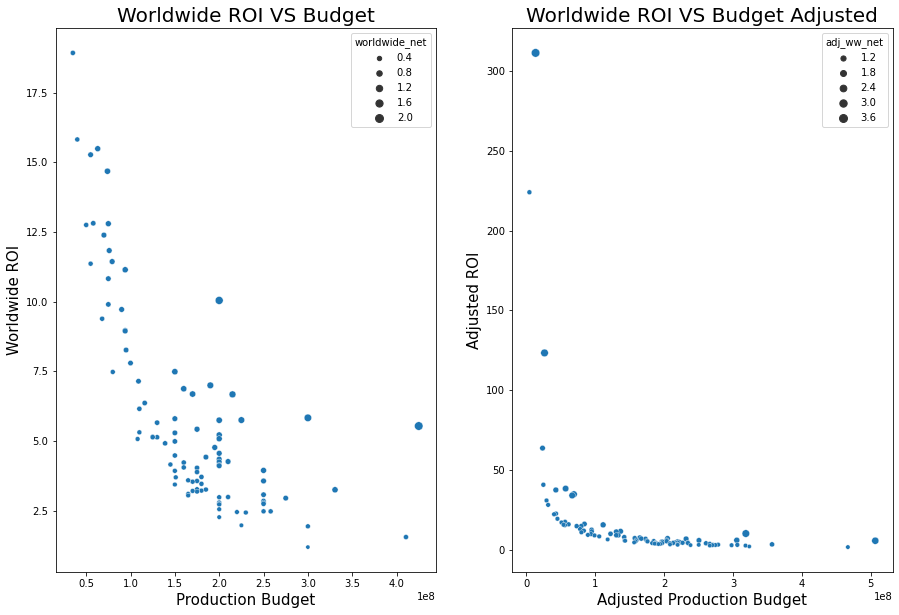

In [34]:
fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(15,10))

sns.scatterplot(x='production_budget', y='worldwide_roi', data=top100_gross_films, size='worldwide_net', ax=ax1)

sns.scatterplot(x='adj_prod_budg', y='adj_ww_roi', data=top100_adj_gross_films, size='adj_ww_net', ax=ax2)

#label for x-axis 
ax1.set_xlabel( "Production Budget" , fontsize=15 )
ax2.set_xlabel("Adjusted Production Budget", fontsize=15)
#label for y-axis 
ax1.set_ylabel( "Worldwide ROI", fontsize=15)
ax2.set_ylabel("Adjusted ROI", fontsize=15)
# setting title
ax1.set_title("Worldwide ROI VS Budget", fontsize=20)
ax2.set_title("Worldwide ROI VS Budget Adjusted", fontsize=20)
plt.show()

In [35]:
title_net = dfr[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'year']]
unique_titles = title_net.groupby('title').first().reset_index()
top100_net_films = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top100_net_films.head()

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,year
352,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,1942
2795,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,1937
3920,Titanic,3.185757e+08,3.517408e+09,3.198832e+09,1997
321,Avatar,5.064591e+08,3.308483e+09,2.802024e+09,2009
3241,The Exorcist,6.909649e+07,2.465676e+09,2.396580e+09,1973


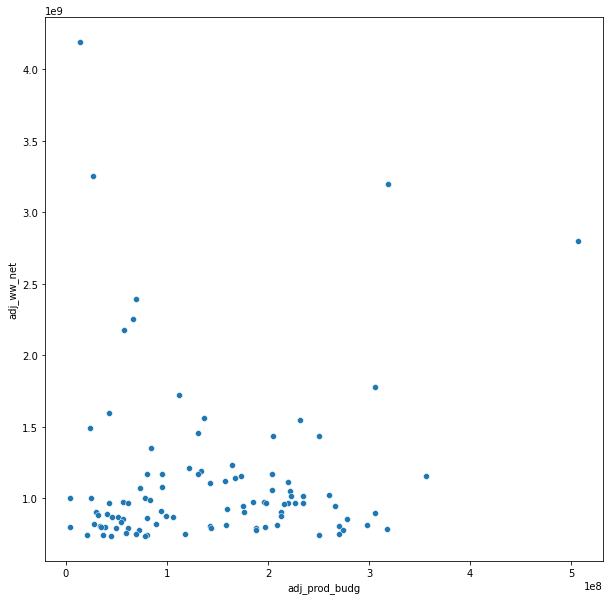

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(data=top100_net_films, x="adj_prod_budg", y="adj_ww_net")
plt.show()

In [37]:
title_roi = dfr[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_roi', 'year']]
unique_titles = title_roi.groupby('title').first().reset_index()
top20_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(20)
top20_roi_films.head()

,title,adj_prod_budg,adj_ww_gross,adj_ww_roi,year
1909,Mad Max,620526.699029,3.094877e+08,497.750000,1980
2303,Paranormal Activity,536250.856496,2.314018e+08,430.517853,2009
3294,The Gallows,107864.414789,4.493251e+07,415.564740,2015
3090,The Blair Witch Project,920733.493397,3.810302e+08,412.833333,1999
2936,Super Size Me,87970.910535,3.009121e+07,341.058585,2004


## Top Talent Preliminary Work

In [38]:
# creating talent dataframe by joining the four tables and printing first row
q = """SELECT*FROM imdb_name_basics
       JOIN imdb_title_principals 
       USING(nconst)
       JOIN imdb_title_basics AS ib
       USING(tconst)
       JOIN tn_movie_budgets AS tn
       ON ib.primary_title = tn.movie
       
       """
dfi = pd.DataFrame(fetcha(q))
dfi.columns = [i[0] for i in cur.description]
dfi.head(1)     

,idx,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,idx,tconst,ordering,...,start_year,runtime_minutes,genres,idx,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",466550,tt2398241,9,...,2017,90.0,"Adventure,Animation,Comedy",904,5,"Apr 7, 2017",Smurfs: The Lost Village,"$60,000,000","$45,020,282","$197,578,586"


In [39]:
# checking columns
dfi.columns

Index(['idx', 'nconst', 'primary_name', 'birth_year', 'death_year',
       'primary_profession', 'known_for_titles', 'idx', 'tconst', 'ordering',
       'category', 'job', 'characters', 'idx', 'primary_title',
       'original_title', 'start_year', 'runtime_minutes', 'genres', 'idx',
       'id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

In [40]:
# checking dtypes
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32406 entries, 0 to 32405
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idx                 32406 non-null  int64  
 1   nconst              32406 non-null  object 
 2   primary_name        32406 non-null  object 
 3   birth_year          14742 non-null  float64
 4   death_year          591 non-null    float64
 5   primary_profession  31872 non-null  object 
 6   known_for_titles    32012 non-null  object 
 7   idx                 32406 non-null  int64  
 8   tconst              32406 non-null  object 
 9   ordering            32406 non-null  int64  
 10  category            32406 non-null  object 
 11  job                 9556 non-null   object 
 12  characters          13012 non-null  object 
 13  idx                 32406 non-null  int64  
 14  primary_title       32406 non-null  object 
 15  original_title      32406 non-null  object 
 16  star

In [41]:
# dropping extraneous columns
dfi = dfi.drop(['idx', 'birth_year', 'death_year', 'primary_profession',\
              'primary_title', 'original_title', 'id',\
              'known_for_titles', 'ordering',\
              'job', 'characters', 'start_year','runtime_minutes'], axis=1)
dfi = dfi.rename(columns = {'movie':'title', 'release_date':'date'})
dfi.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy","Apr 7, 2017",Smurfs: The Lost Village,"$60,000,000","$45,020,282","$197,578,586"


In [42]:
# checking numbers of NaNs
dfi.isna().sum()

nconst                 0
primary_name           0
tconst                 0
category               0
genres               260
date                   0
title                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
dtype: int64

In [43]:
#cleaning numerical strings and converting to floats
dfi['worldwide_gross'] = dfi['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['domestic_gross'] = dfi['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['production_budget'] = dfi['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [44]:
# change date string to datetime object 
dfi.date = pd.to_datetime(dfi.date)
dfi['year'] = dfi['date'].apply(lambda x: x.year)
dfi['month'] = dfi['date'].apply(lambda x: x.month)

In [45]:
# creating intl gross column
dfi['international_gross'] = dfi['worldwide_gross'].sub(dfi['domestic_gross'])

In [46]:
# defining function to adjust for inflation because the year
# 2020 throws errors when applying cpi.inflate

def adjust_for_inf(row, name):
    if row.year != 2020:
        value = cpi.inflate(row[name], row.year)
    else:
        value = row[name]
    return value

In [47]:
#adding adjusted budget and gross profit columns
dfi['adj_prod_budg'] = dfi.apply(lambda x: adjust_for_inf(x, 'production_budget'), axis=1)
dfi['adj_dom_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'domestic_gross'), axis=1)
dfi['adj_ww_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'worldwide_gross'), axis=1)
dfi['adj_i_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'international_gross'), axis=1)

In [48]:
#adding net profit columns
dfi['adj_dom_net'] = dfi['adj_dom_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_ww_net'] = dfi['adj_ww_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_i_net'] = dfi['adj_i_gross'].sub(dfi['adj_prod_budg'])

In [49]:
#adding return on investment columns and checking results
dfi['adj_dom_roi'] = dfi['adj_dom_net'].divide(dfi['adj_prod_budg'])
dfi['adj_ww_roi'] = dfi['adj_ww_net'].divide(dfi['adj_prod_budg'])
dfi['adj_i_roi'] = dfi['adj_i_net'].divide(dfi['adj_prod_budg'])
dfi.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,...,adj_prod_budg,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,...,6.257923e+07,4.695557e+07,2.060719e+08,1.591163e+08,-1.562365e+07,1.434927e+08,9.653712e+07,-0.249662,2.292976,1.542638


In [50]:
# creating imdb top adj goss list dataframes
title_adj_gross_i = dfi[['title', 'adj_ww_gross', 'date']]
unique_titles = title_adj_gross_i.drop_duplicates(subset = ['title'])
top20_adj_gross_films_i = unique_titles.sort_values(by='adj_ww_gross', ascending=False).head(20)
top100_adj_gross_films_i = unique_titles.sort_values(by='adj_ww_gross', ascending=False).head(100)
top20_adj_gross_films_i

,title,adj_ww_gross,date
6985,Bambi,4.203440e+09,1942-08-13
4866,Titanic,3.517408e+09,1997-12-19
16889,Avatar,3.308483e+09,2009-12-18
2320,Snow White and the Seven Dwarfs,3.283159e+09,1937-12-21
485,Avengers: Infinity War,2.085246e+09,2018-04-27
258,Jurassic World,1.778528e+09,2015-06-12
575,The Lion King,1.701301e+09,1994-06-15
1020,The Avengers,1.690249e+09,2012-05-04
447,Furious 7,1.638161e+09,2015-04-03
12913,Fantasia,1.521524e+09,1940-11-13


In [51]:
# creating imdb top adj net list dataframes
title_net_i = dfi[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_net' ,'date']]
unique_titles = title_net_i.drop_duplicates(subset = ['title'])
top20_adj_net_films_i = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(20)
top100_adj_net_films_i = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top20_adj_net_films_i

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,date
6985,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,1942-08-13
2320,Snow White and the Seven Dwarfs,2.641789e+07,3.283159e+09,3.256741e+09,1937-12-21
4866,Titanic,3.185757e+08,3.517408e+09,3.198832e+09,1997-12-19
16889,Avatar,5.064591e+08,3.308483e+09,2.802024e+09,2009-12-18
485,Avengers: Infinity War,3.054359e+08,2.085246e+09,1.779810e+09,2018-04-27
575,The Lion King,1.367989e+08,1.701301e+09,1.564502e+09,1994-06-15
258,Jurassic World,2.319085e+08,1.778528e+09,1.546619e+09,2015-06-12
12913,Fantasia,4.163557e+07,1.521524e+09,1.479889e+09,1940-11-13
1020,The Avengers,2.505415e+08,1.690249e+09,1.439707e+09,2012-05-04
447,Furious 7,2.049424e+08,1.638161e+09,1.433219e+09,2015-04-03


In [52]:
# creating imdb top adj roi list dataframes
title_roi_i = dfi[['title','adj_prod_budg',  'adj_ww_net', 'adj_ww_roi', 'date']]
unique_titles = title_roi_i.drop_duplicates(subset = ['title'])
top20_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(20)
top100_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(100)
top20_roi_films

,title,adj_prod_budg,adj_ww_net,adj_ww_roi,date
1230,The Gallows,1.078644e+05,4.482465e+07,415.564740,2015-07-10
6985,Bambi,1.345728e+07,4.189983e+09,311.354312,1942-08-13
2089,Rocky,4.493093e+06,1.006453e+09,224.000000,1976-11-21
2320,Snow White and the Seven Dwarfs,2.641789e+07,3.256741e+09,123.277880,1937-12-21
1654,The Devil Inside,1.113518e+06,1.121975e+08,100.759490,2012-01-06
2126,Graduation Day,7.031271e+05,6.649895e+07,94.576000,1981-05-01
1221,Insidious,1.704842e+06,1.118046e+08,65.580591,2011-04-01
5917,Unfriended,1.078644e+06,6.834742e+07,63.364198,2015-04-17
1224,Benji,2.592870e+06,1.610668e+08,62.119120,1974-11-15
1220,Paranormal Activity 2,3.517312e+06,2.046044e+08,58.170677,2010-10-20


##  Top Creative Talent

In [53]:
#  getting job titles
dfi.category.unique()

array(['producer', 'composer', 'actor', 'cinematographer', 'director',
       'writer', 'actress', 'editor', 'production_designer', 'self',
       'archive_footage', 'archive_sound'], dtype=object)

## Top 20 Actors By Adjusted Gross

In [54]:
#  dropping problematic titles
dfi = dfi[dfi.title != 'Titanic']
dfi = dfi[dfi.title != 'Cinderella']
dfi = dfi[dfi.title != 'Snow White and the Seven Dwarfs']
dfi = dfi[dfi.title != 'Beauty and the Beast']

In [55]:
# creating actor dataframe
actor_df = dfi[dfi['category'].str.contains('actor')]

In [56]:
# creating preliminary top 100 actors list
top100_grossing_actors = actor_df.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(100) 
top100_actors = pd.DataFrame(top100_grossing_actors)
top100_actors.head()

,adj_ww_gross
primary_name,
Robert Downey Jr.,1.049882e+10
Dwayne Johnson,8.735245e+09
Chris Evans,7.979593e+09
Chris Hemsworth,6.594242e+09
Mark Ruffalo,5.775902e+09


In [57]:
# resetting index
reset_idx = top100_actors.reset_index()

In [58]:
# getting name list
actor_list = list(reset_idx.primary_name)

In [59]:
# running imdb actor list against rt movie list to work-around problematic titles and get more accurate gross values.
gross = []
for name in actor_list:
    value = dfr[dfr['actors'].str.contains(name)].adj_ww_gross.sum()
    gross.append(value)
gross[:5]

[11347372028.952734,
 10805639553.785833,
 8573423129.69062,
 7718332727.016749,
 7046639100.414162]

In [60]:
#  creating new adj gross dataframe
dict = {'primary_name': actor_list, 'adj_ww_gross': gross}
gross_df = pd.DataFrame(dict, index=actor_list)
top50_adj_gross_actors = gross_df.sort_values(by='adj_ww_gross', ascending=False).head(50)
top50_adj_gross_actors.head()

,primary_name,adj_ww_gross
Samuel L. Jackson,Samuel L. Jackson,1.942438e+10
Ian McKellen,Ian McKellen,1.386912e+10
Tom Hanks,Tom Hanks,1.327989e+10
Andy Serkis,Andy Serkis,1.271168e+10
Stanley Tucci,Stanley Tucci,1.179104e+10


In [61]:
# getting movie count
movie_count_m = actor_df.groupby(['primary_name']).title.count()
count_m = pd.DataFrame(movie_count_m)
count_m.head(1)

,title
primary_name,
50 Cent,2


In [62]:
# joining dfs
joined_m = top50_adj_gross_actors.join(count_m)
joined_m.head(1)

,primary_name,adj_ww_gross,title
Samuel L. Jackson,Samuel L. Jackson,1.942438e+10,12


In [63]:
# adding mean gross column
joined_m['mean_gross'] = joined_m.adj_ww_gross/joined_m.title
joined_m = joined_m.reset_index()
joined_m = joined_m.rename(columns={'primary_name': 'Actor',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [64]:
# sorting top 20 cumulative gross and mean gross films
top20_cuml_gross_actors =  joined_m.sort_values(by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actors = joined_m.sort_values(by='Mean Gross per Title', ascending=False).head(20)

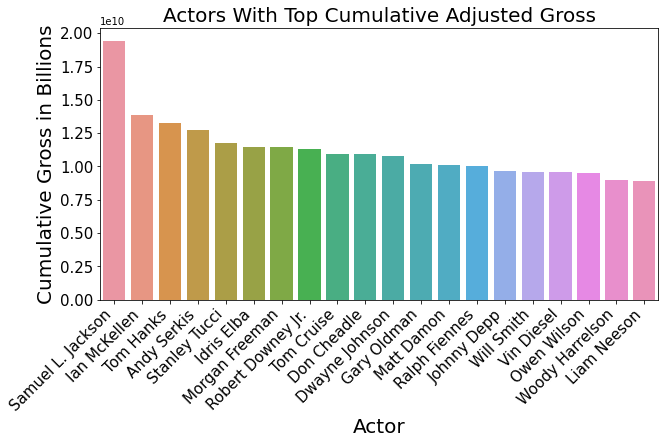

In [65]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Cumulative Gross', data=top20_cuml_gross_actors)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actor", fontsize=20 )
ax.set_ylabel( "Cumulative Gross in Billions" , fontsize=20 )
ax.set_title("Actors With Top Cumulative Adjusted Gross", fontsize=20)
plt.show()

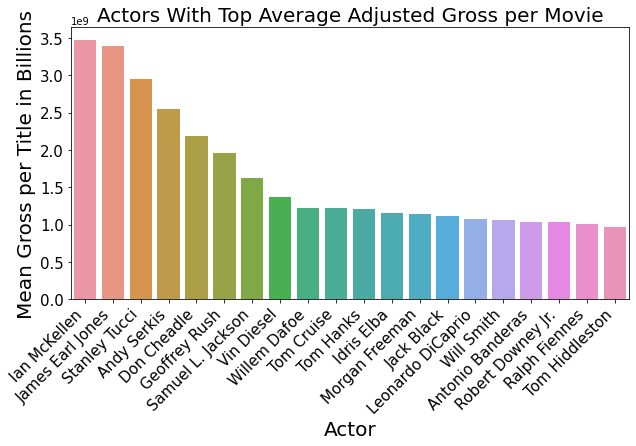

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Mean Gross per Title', data=top20_mean_gross_actors)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actor", fontsize=20 ) 
ax.set_ylabel( "Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Actors With Top Average Adjusted Gross per Movie", fontsize=20) 
plt.show() 

## Top 20 Actresses By Adjusted Gross

In [67]:
# creating actress df
actress_df = dfi[dfi['category'].str.contains('actress')]

In [68]:
# initial top 100
top100_grossing_actresses = actress_df.groupby(['primary_name']).adj_ww_gross.sum().sort_values(ascending=False).head(100) 
top100_actresses = pd.DataFrame(top100_grossing_actresses)
top100_actresses.head()

,adj_ww_gross
primary_name,
Jennifer Lawrence,5.561662e+09
Scarlett Johansson,5.386301e+09
Anne Hathaway,5.110396e+09
Kristen Wiig,4.588155e+09
Cate Blanchett,3.956661e+09


In [69]:
# resetting index
reset_idx_f = top100_actresses.reset_index()

In [70]:
# getting name list
actress_list = list(reset_idx_f.primary_name)

In [71]:
# running imdb actress list against rt movie list to work-around problematic titles and get more accurate gross values.
gross_f = []
for name in actress_list:
    value = dfr[dfr['actors'].str.contains(name)].adj_ww_gross.sum()
    gross_f.append(value)
gross_f[:5]

[6420782167.258479,
 10401039662.879757,
 7137027231.28934,
 6917248867.511726,
 16523303003.084745]

In [72]:
#  creating new adj gross dataframe
dict = {'primary_name': actress_list, 'adj_ww_gross': gross_f}
gross_df_f = pd.DataFrame(dict, index=actress_list)
top50_adj_gross_actresses = gross_df_f.sort_values(by='adj_ww_gross', ascending=False).head(50)
top50_adj_gross_actresses.head()

,primary_name,adj_ww_gross
Cate Blanchett,Cate Blanchett,1.652330e+10
Scarlett Johansson,Scarlett Johansson,1.040104e+10
Helena Bonham Carter,Helena Bonham Carter,1.022473e+10
Zoe Saldana,Zoe Saldana,9.700543e+09
Michelle Rodriguez,Michelle Rodriguez,9.257438e+09


In [73]:
# movie count
movie_count_f = actress_df.groupby(['primary_name']).title.count()
count_f = pd.DataFrame(movie_count_f)
count_f.head(1)

,title
primary_name,
AJ Michalka,2


In [74]:
# joining dfs
joined_f = top50_adj_gross_actresses.join(count_f)
joined_f.head(1)

,primary_name,adj_ww_gross,title
Cate Blanchett,Cate Blanchett,1.652330e+10,10


In [75]:
# added mean gross column
joined_f['mean_gross'] = joined_f.adj_ww_gross/joined_f.title
joined_f = joined_f.reset_index()
joined_f = joined_f.rename(columns={'primary_name': 'Actress',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [76]:
# sorting top 20s
top20_cuml_gross_actresses =  joined_f.sort_values(by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actresses = joined_f.sort_values(by='Mean Gross per Title', ascending=False).head(20)

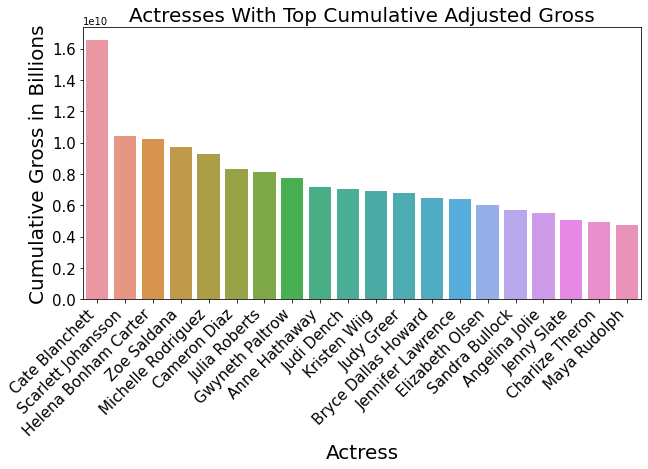

In [77]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Cumulative Gross', data=top20_cuml_gross_actresses)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actress", fontsize=20 )
ax.set_ylabel( "Cumulative Gross in Billions" , fontsize=20 )
ax.set_title("Actresses With Top Cumulative Adjusted Gross", fontsize=20)
plt.show()

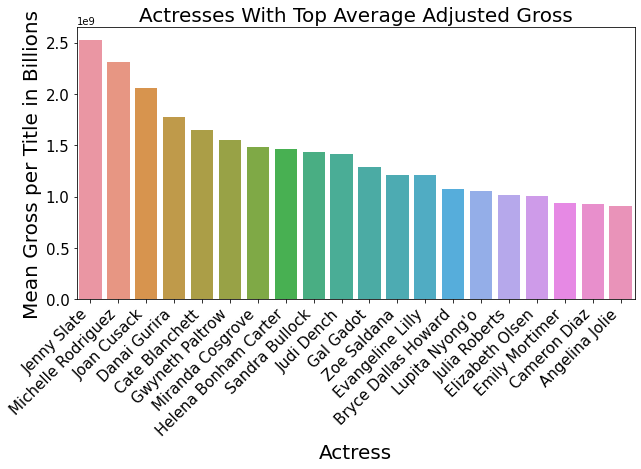

In [85]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Mean Gross per Title', data=top20_mean_gross_actresses)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actress", fontsize=20 ) 
ax.set_ylabel( "Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Actresses With Top Average Adjusted Gross", fontsize=20) 
plt.show() 

In [79]:
split_list = []
for genre in dfr.genres:
    split_list += genre.split(',')

raw_genres = list(set(split_list))
raw_genres

[' Faith & Spirituality',
 ' Classics',
 'Romance',
 'Western',
 ' Gay & Lesbian',
 'Action & Adventure',
 ' Musical & Performing Arts',
 'Musical & Performing Arts',
 ' Cult Movies',
 'Drama',
 'Documentary',
 ' Science Fiction & Fantasy',
 ' Television',
 ' Anime & Manga',
 ' Romance',
 ' Art House & International',
 'Animation',
 ' Kids & Family',
 ' Horror',
 ' Animation',
 'Mystery & Suspense',
 'Cult Movies',
 'Classics',
 'Science Fiction & Fantasy',
 ' Mystery & Suspense',
 'Art House & International',
 ' Comedy',
 'Kids & Family',
 ' Drama',
 ' Special Interest',
 'Comedy',
 'Horror',
 ' Western',
 ' Sports & Fitness',
 ' Documentary']

In [80]:
split_list = []
for genre in dfr.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres = list(set(split_list))
genres

['horror',
 'art house & international',
 'cult movies',
 'action & adventure',
 'classics',
 'animation',
 'documentary',
 'drama',
 'western',
 'gay & lesbian',
 'sports & fitness',
 'mystery & suspense',
 'anime & manga',
 'faith & spirituality',
 'romance',
 'television',
 'science fiction & fantasy',
 'kids & family',
 'musical & performing arts',
 'comedy',
 'special interest']

In [81]:
len(genres)

21

In [82]:
action = dfr[(dfr['genres'] == 'Action & Adventure')]
unique_titles = action.groupby('title').first().reset_index()
top100_action = unique_titles.sort_values(by='adj_ww_net', ascending=False)
top100_action

,title,idx,rotten_tomatoes_link,movie_info,critics_consensus,rating,genres,directors,authors,actors,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
60,The Avengers,1197,m/1083461-avengers,A charismatic evil genius named Sir August de ...,"A TV spinoff that lacks enough energy to spin,...",PG-13,Action & Adventure,Jeremiah S. Chechik,Don MacPherson,"Ralph Fiennes, Uma Thurman, Sean Connery, Eile...",...,6.940329e+08,1.690249e+09,9.962157e+08,2.505415e+08,4.434914e+08,1.439707e+09,7.456742e+08,1.770131,5.746382,2.976250
48,Raiders of the Lost Ark,12247,m/raiders_of_the_lost_ark,"Dr. Indiana Jones, a renowned archeologist and...","Featuring bravura set pieces, sly humor, and w...",PG,Action & Adventure,Steven Spielberg,Lawrence Kasdan,"Harrison Ford, Karen Allen, Paul Freeman, Wolf...",...,6.347440e+08,1.033462e+09,3.987180e+08,5.625017e+07,5.784938e+08,9.772118e+08,3.424679e+08,10.284304,17.372604,6.088300
27,Indiana Jones and the Last Crusade,8342,m/indiana_jones_and_the_last_crusade,An art collector appeals to Jones to embark on...,"Lighter and more comedic than its predecessor,...",PG-13,Action & Adventure,Steven Spielberg,Jeffrey Boam,"Harrison Ford, Sean Connery, Alison Doody, Den...",...,4.065190e+08,9.776237e+08,5.711048e+08,9.896400e+07,3.075550e+08,8.786597e+08,4.721408e+08,3.107746,8.878579,4.770833
28,Indiana Jones and the Temple of Doom,8343,m/indiana_jones_and_the_temple_of_doom,The second of the Lucas/Spielberg Indiana Jone...,"It may be too ""dark"" for some, but Indiana Jon...",PG,Action & Adventure,Steven Spielberg,"Gloria Katz, Steven Spielberg, George Lucas, W...","Harrison Ford, Kate Capshaw, Jonathan Ke Quan,...",...,4.426145e+08,8.195794e+08,3.769649e+08,6.889698e+07,3.737176e+08,7.506825e+08,3.080679e+08,5.424295,10.895724,4.471429
26,Indiana Jones and the Kingdom of the Crystal S...,8341,m/indiana_jones_and_the_kingdom_of_the_crystal...,"It's the height of the Cold War, and famous ar...",Though the plot elements are certainly familia...,PG-13,Action & Adventure,Steven Spielberg,David Koepp,"Harrison Ford, Shia LaBeouf, Cate Blanchett, K...",...,3.765350e+08,9.340736e+08,5.575386e+08,2.196743e+08,1.568607e+08,7.143993e+08,3.378642e+08,0.714060,3.252083,1.538023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,Ironclad,8478,m/ironclad,"In the 13th century, a dedicated group of Knig...",Ironclad serves up plenty of crunchy gore to s...,R,Action & Adventure,Jonathan English,"Erick Kastel, Jonathan English, Stephen McDool","James Purefoy, Brian Cox, Derek Jacobi, Paul G...",...,0.000000e+00,6.020833e+06,6.020833e+06,2.841404e+07,-2.841404e+07,-2.239320e+07,-2.239320e+07,-1.000000,-0.788104,-0.788104
68,The Gunman,15101,m/the_gunman_2015,Eight years after fleeing the Congo following ...,With an uninspired plot and rote set pieces th...,R,Action & Adventure,Pierre Morel,"Don MacPherson, Pete Travis","Sean Penn, Idris Elba, Jasmine Trinca, Javier ...",...,1.150347e+07,2.005655e+07,8.553085e+06,4.314577e+07,-3.164230e+07,-2.308921e+07,-3.459268e+07,-0.733381,-0.535144,-0.801763
22,Harley Davidson and the Marlboro Man,7507,m/harley_davidson_and_the_marlboro_man,"In this action movie, tough biker Harley David...",None,R,Action & Adventure,Simon Wincer,"Don Michael Paul, Simon Wincer","Mickey Rourke, Don Johnson, Chelsea Field, Dan...",...,1.317427e+07,1.317427e+07,0.000000e+00,4.317262e+07,-2.999836e+07,-2.999836e+07,-4.317262e+07,-0.694847,-0.694847,-1.000000
42,Mortdecai,10602,m/mortdecai,Charismatic British aristocrat and part-time s...,"Aggressively strange and willfully unfunny, th...",R,Action & Adventure,David Koepp,"Eric Aronson, David Koepp","Johnny Depp, Gwyneth Paltrow, Ewan McGregor, O...",...,8.301390e+06,3.278661e+07,2.448522e+07,6.471865e+07,-5.641726e+07,-3.193204e+07,-4.023343e+07,-0.871731,-0.493398,-0.621667


In [83]:
scifi = dfr[(dfr['genres'].str.contains('science fiction & fantasy', case=False))]
unique_titles = scifi.drop_duplicates(subset = ['title'])
top100_scifi = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top100_scifi

,idx,rotten_tomatoes_link,title,movie_info,critics_consensus,rating,genres,directors,authors,actors,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
1054,3156,m/bambi,Bambi,"In a classic Disney animation, a fawn named Ba...","Elegantly animated and deeply touching, Bambi ...",G,"Animation, Classics, Kids & Family, Science Fi...","David Hand, Samuel Armstrong, Bill Roberts, Ja...","Larry Morey, Perce Pearce, Chuck Couch, Ralph ...","Bobby Stewart, Paula Winslowe, Paul Behn, Pete...",...,1.612317e+09,4.203440e+09,2.591123e+09,1.345728e+07,1.598860e+09,4.189983e+09,2.577666e+09,118.810023,311.354312,191.544289
357,991,m/1048445-snow_white_and_the_seven_dwarfs,Snow White and the Seven Dwarfs,The Grimm fairy tale gets a Technicolor treatm...,"With its involving story and characters, vibra...",G,"Animation, Classics, Kids & Family, Science Fi...","David Hand, William Cottrell, David D. Hand, W...","Dorothy Anne Blank, Dick Richards, Ted Sears, ...","Adriana Caselotti, Marge Champion, Harry Stock...",...,3.283159e+09,3.283159e+09,0.000000e+00,2.641789e+07,3.256741e+09,3.256741e+09,-2.641789e+07,123.277880,123.277880,-1.000000
1019,3027,m/avatar,Avatar,On the lush alien world of Pandora live the Na...,It might be more impressive on a technical lev...,PG-13,"Action & Adventure, Comedy, Mystery & Suspense...",James Cameron,James Cameron,"Zoe Saldana, Sam Worthington, Sigourney Weaver...",...,9.062730e+08,3.308483e+09,2.402210e+09,5.064591e+08,3.998139e+08,2.802024e+09,1.895751e+09,0.789430,5.532577,3.743147
1021,3032,m/avengers_infinity_war,Avengers: Infinity War,"Iron Man, Thor, the Hulk and the rest of the A...",Avengers: Infinity War ably juggles a dizzying...,PG-13,"Action & Adventure, Science Fiction & Fantasy",Anthony Russo,"Christopher Markus, Stephen McFeely","Robert Downey Jr., Chris Hemsworth, Mark Ruffa...",...,6.911155e+08,2.085246e+09,1.394130e+09,3.054359e+08,3.856795e+08,1.779810e+09,1.088695e+09,1.262718,5.827114,3.564396
2529,8824,m/jurassic_park,Jurassic Park,"In Steven Spielberg's massive blockbuster, pal...",Jurassic Park is a spectacle of special effect...,PG-13,"Action & Adventure, Mystery & Suspense, Scienc...",Steven Spielberg,"John Micheal Crichton, Michael Crichton, David...","Richard Attenborough, Sam Neill, Laura Dern, J...",...,7.001079e+08,1.837922e+09,1.137814e+09,1.114629e+08,5.886450e+08,1.726459e+09,1.026351e+09,5.281084,15.489089,9.208004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3900,14095,m/superman_man_of_steel,Man of Steel,"With the imminent destruction of Krypton, thei...",Man of Steel's exhilarating action and spectac...,PG-13,"Action & Adventure, Science Fiction & Fantasy",Zack Snyder,"Christopher Nolan, Kurt Johnstad, David S. Goyer","Henry Cavill, Amy Adams, Michael Shannon, Dian...",...,3.194058e+08,7.330913e+08,4.136855e+08,2.469246e+08,7.248118e+07,4.861667e+08,1.667608e+08,0.293536,1.968887,0.675351
706,1761,m/1209933-puss_in_boots,Puss in Boots,"Long before meeting Shrek, Puss in Boots (Anto...","It isn't deep or groundbreaking, but what it l...",PG,"Action & Adventure, Animation, Comedy, Kids & ...",Chris Miller,"Chris Miller, Tom Wheeler","Antonio Banderas, Salma Hayek, Zach Galifianak...",...,1.696437e+08,6.307774e+08,4.611336e+08,1.477530e+08,2.189075e+07,4.830244e+08,3.133807e+08,0.148158,3.269134,2.120977
3684,13302,m/signs,Signs,Everything that farmer Graham Hess (Mel Gibson...,"With Signs, Shyamalan proves once again an exp...",PG-13,"Mystery & Suspense, Science Fiction & Fantasy",M. Night Shyamalan,M. Night Shyamalan,"Mel Gibson, Joaquin Phoenix, Abigail Breslin, ...",...,3.239686e+08,5.801940e+08,2.562254e+08,1.004759e+08,2.234926e+08,4.797181e+08,1.557495e+08,2.224340,4.774458,1.550118
1414,4598,m/cinderella,Cinderella,With a wicked stepmother (Eleanor Audley) and ...,"The rich colors, sweet songs, adorable mice an...",G,"Animation, Classics, Kids & Family, Sc

In [84]:
list(dfr[dfr['title'] == 'Mad Max'].genres)

['Action & Adventure, Cult Movies, Science Fiction & Fantasy']